### Objective

In this notebook, we develop a PI-DeepONet model that can tackle inverse problems. Specifically, we investigate the following example equation:

\begin{equation}
\frac{ds(t)}{dt} = a \cdot u(t)+b, \; t \in [0, 1]
\end{equation}

with an initial condition $s(0)=0$, and our goal is to estimate unknown parameters a and b given the observed input and output functions.

### 0. Import libraries

In [2]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import solve_ivp

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### 1. Data generation

We use a zero-mean Gaussian Process to generate the dataset for both training and testing.

In [3]:
def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)
    
    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate
    
    Outputs:
    --------
    u_sample: generated u(·) profiles
    """
    
    # Define kernel with given length scale
    kernel = RBF(length_scale)

    # Create Gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel)

    # collocation point locations
    X_sample = np.linspace(0, 1, 100).reshape(-1, 1) 
    
    # create samples
    u_sample = np.zeros((sample_num, 100))
    for i in range(sample_num):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()  # sampling from the prior
        
    return u_sample

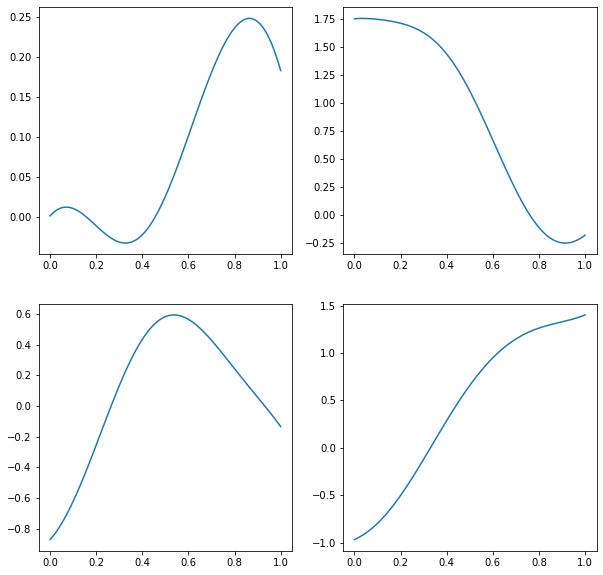

In [4]:
# Inspect generated data 
length_scale = 0.4
N = 20
X_sample = np.linspace(0, 1, 100).reshape(-1, 1) 
y_sample = create_samples(length_scale, N)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, y_sample[index[i]])

### 2. Organize dataset for PI-DeepONet

In [5]:
def generate_dataset(N, length_scale, a, b, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.
    
    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)
    
    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """
    
    # Create random fields
    random_field = create_samples(length_scale, N)
    
    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N)):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: a*np.interp(var_t, t.flatten(), random_field[i, :])+b, 
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)
        
    return X, y

In [6]:
# Define true parameter values
a, b = 0.5, 0.5

# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train, a, b, ODE_solve=True)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test, a, b, ODE_solve=True)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, a, b, ODE_solve=True)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 646.83it/s]


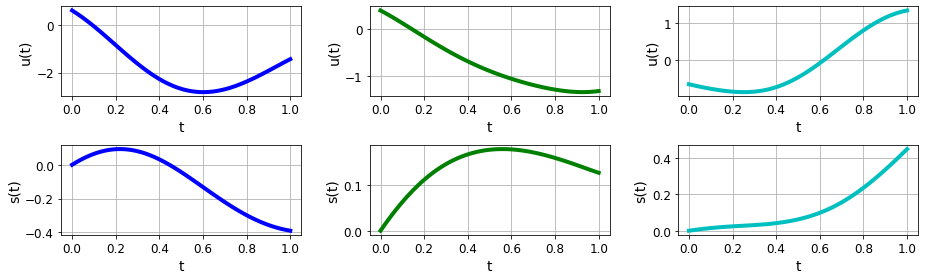

In [12]:
%matplotlib inline
color = ['b', 'g', 'c']
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1], lw=4, c=color[i])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    
    
    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y_test[sample_id[i]*100:(sample_id[i]+1)*100, :], lw=4, c=color[i])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)

plt.tight_layout()
plt.savefig('inverse_param_sample.png', bbox_inches='tight', transparent=True)

#### Separate initial condition and collocation points

In [13]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
y_train_ini = tf.convert_to_tensor(y_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini, y_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Scaling 
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

### 3. Physics-informed DeepONet

#### Define a custom layer for adding a bias

In [14]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

#### Define a custom layer for hosting unknown parameters

In [15]:
class ParameterLayer(tf.keras.layers.Layer):
    def __init__(self, a, b, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self._b = tf.convert_to_tensor(b, dtype=tf.float32)
        self.trainable = trainable
        
    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        self.b = self.add_weight("b", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._b),
                                 trainable=self.trainable)
        
    def get_config(self):
        return super().get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Define Physics-informed DeepONet

In [16]:
def create_model(mean, var, a_init=None, b_init=None, trainable=None, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.
    
    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    a_init: float, initial value for parameter a
    b_init: float, initial value for parameter b
    trainable: boolean, indicate whether the parameters a and b will be updated during training
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the DeepONet model
    """
    
    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['forcing'])), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)
    
    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)   
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)
    
    # Merge results 
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)
    
    # Add the bias
    dot_product_with_bias = BiasLayer()(dot_product)

    # Add a & b trainable parameters
    output = ParameterLayer(a_init, b_init, trainable)(dot_product_with_bias)
    
    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)
    
    if verbose:
        model.summary()
        
    return model   

#### ODE loss

In [17]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.
    
    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model
    
    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    
    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"forcing": u, "time": t})
    
    # Calculate gradients
    ds_dt = tape.gradient(s, t)
    
    # ODE residual
    ODE_residual = ds_dt - model.layers[-1].a*u_t - model.layers[-1].b
    
    return ODE_residual

#### Gradient descent step

In [18]:
@tf.function
def train_step(X, y, X_init, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    
    Args:
    ----
    X: training dataset for evaluating ODE residuals
    y: target value of the training dataset
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    data_weight: weight for data loss
    model: DeepONet model
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    data_loss: calculated data loss
    total_loss: weighted sum of ODE loss, initial condition loss, and data loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)
        
        # Data loss
        y_pred_data = model({"forcing": X[:, 1:-1], "time": X[:, :1]})

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))
        
        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

#### Define Loss Tracking class

In [19]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")
        
    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

#### Define callback

In [20]:
class PrintParameters(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}, b: {self.model.layers[-1].b.numpy()}")

#### Training

In [45]:
# Set up training configurations
n_epochs = 100
IC_weight= tf.constant(1.0, dtype=tf.float32)   
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list, b_list = [], []

# Initial value for unknown parameters
a, b = 0.2, 0.8

# One test sample prediction
pred_profiles = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):
    
    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var, a_init=a, b_init=b, trainable=True)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)
    
    # Start training process
    for epoch in range(1, n_epochs + 1):  
        print(f"Epoch {epoch}:")

        for (X_init, _), (X, y) in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X, y, X_init, 
                                                                            IC_weight, ODE_weight,
                                                                            data_weight, PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()
        
        # Parameter recording
        a_list.append(PI_DeepONet.layers[-1].a.numpy())
        b_list.append(PI_DeepONet.layers[-1].b.numpy())

        ####### Validation
        pred_valid = PI_DeepONet.predict({"forcing": X_val[:, 1:-1], "time": X_val[:, :1]}, batch_size=12800)
        val_loss = tf.reduce_mean(keras.losses.mean_squared_error(y_val, pred_valid))
        print(f"val_loss: {val_loss:.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_loss})
        val_loss_hist.append(val_loss)

        # Test dataset
        pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")
        
        # Predict on one specific test samples
        sample_id = 25
        pred_profiles.append(PI_DeepONet.predict({"forcing": X_test[sample_id*100:(sample_id+1)*100, 1:-1], 
                                            "time": X_test[sample_id*100:(sample_id+1)*100, :1]}, batch_size=12800))
        
        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini, y_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size) 

Epoch 1:
IC=3.2399e-02,               ODE=1.4458e-01,               data=4.1626e-02,               total_loss=2.1860e-01
val_loss: 1.4196e-02, lr: 1.00e-03

a: [0.1917288], b: [0.75144815]
RMSE: 0.1348638130316244
Epoch 2:
IC=5.9144e-03,               ODE=1.2610e-02,               data=1.4432e-02,               total_loss=3.2956e-02
val_loss: 1.1212e-02, lr: 1.00e-03

a: [0.2251221], b: [0.7282011]
RMSE: 0.12109151971960719
Epoch 3:
IC=4.3169e-03,               ODE=6.4989e-03,               data=1.0438e-02,               total_loss=2.1253e-02
val_loss: 8.3674e-03, lr: 1.00e-03

a: [0.2743454], b: [0.70498544]
RMSE: 0.10414600192242332
Epoch 4:
IC=3.0559e-03,               ODE=5.0392e-03,               data=7.4925e-03,               total_loss=1.5588e-02
val_loss: 5.2180e-03, lr: 1.00e-03

a: [0.31846252], b: [0.6824815]
RMSE: 0.08126456087961664
Epoch 5:
IC=2.1813e-03,               ODE=4.3310e-03,               data=5.3584e-03,               total_loss=1.1871e-02
val_loss: 3.3564e-03,

IC=1.4817e-05,               ODE=4.3533e-04,               data=4.6349e-05,               total_loss=4.9650e-04
val_loss: 2.0278e-05, lr: 1.00e-03

a: [0.49315348], b: [0.49974313]
RMSE: 0.0046086479181922865
Epoch 40:
IC=1.4736e-05,               ODE=4.1348e-04,               data=4.5517e-05,               total_loss=4.7373e-04
val_loss: 4.1489e-05, lr: 1.00e-03

a: [0.49321768], b: [0.49959284]
RMSE: 0.005739154108213092
Epoch 41:
IC=1.4196e-05,               ODE=4.1829e-04,               data=4.3242e-05,               total_loss=4.7573e-04
val_loss: 4.0400e-05, lr: 1.00e-03

a: [0.49316773], b: [0.4995317]
RMSE: 0.0056231898938025465
Epoch 42:
IC=1.3289e-05,               ODE=3.7508e-04,               data=3.6350e-05,               total_loss=4.2471e-04
val_loss: 2.0099e-05, lr: 1.00e-03

a: [0.49344274], b: [0.49958658]
RMSE: 0.004593869257320037
Epoch 43:
IC=2.1693e-05,               ODE=5.2936e-04,               data=6.2993e-05,               total_loss=6.1405e-04
val_loss: 2.249

IC=5.7391e-06,               ODE=2.3826e-04,               data=1.7131e-05,               total_loss=2.6113e-04
val_loss: 3.1357e-05, lr: 5.00e-04

a: [0.49590805], b: [0.49992]
RMSE: 0.005648416736805774
Epoch 78:
IC=8.9160e-06,               ODE=2.4751e-04,               data=2.0390e-05,               total_loss=2.7682e-04
val_loss: 8.7666e-06, lr: 5.00e-04

a: [0.49587625], b: [0.4999672]
RMSE: 0.0029148362115946694
Epoch 79:
IC=2.4851e-06,               ODE=1.8292e-04,               data=6.8470e-06,               total_loss=1.9225e-04
val_loss: 6.8864e-06, lr: 2.50e-04

a: [0.49613354], b: [0.4999164]
RMSE: 0.0024847417614077966
Epoch 80:
IC=2.3160e-06,               ODE=1.8052e-04,               data=6.2749e-06,               total_loss=1.8911e-04
val_loss: 7.0916e-06, lr: 2.50e-04

a: [0.49636406], b: [0.49993303]
RMSE: 0.002599206056279432
Epoch 81:
IC=1.9386e-06,               ODE=1.7982e-04,               data=6.4336e-06,               total_loss=1.8819e-04
val_loss: 5.3671e-0

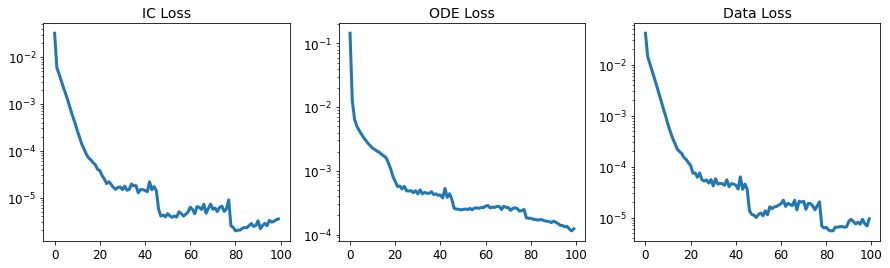

In [46]:
# History for loss
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'], lw=3)
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'], lw=3)
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'], lw=3)
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Data Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)
    
plt.savefig('loss.png', bbox_inches='tight', pad_inches=0, transparent=True)

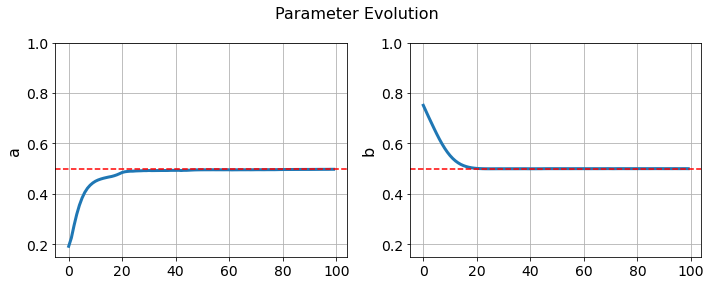

In [49]:
# History for parameters
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(n_epochs), a_list, lw=3)
ax[0].set_ylabel('a', fontsize=16)

ax[1].plot(range(n_epochs), b_list, lw=3)
ax[1].set_ylabel('b', fontsize=16)

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.set_ylim((0.15, 1.0))
    axs.grid(True)
    axs.axhline(y=0.5, color='r', linestyle='--')
fig.suptitle('Parameter Evolution', fontsize=16)
plt.tight_layout()
plt.savefig('inverse_param_estimate.png', bbox_inches='tight', pad_inches=0, transparent=True)